In [ ]:
# In this notebook we're just going to verify the results of Going For Three, which trained a logistic regression model on kicks from 2000 to 2011.
# Initially we use all kickers, not just those that had had at least 50 kicks at the time of the attempt.

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm as glm_sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np
import mysql.connector


In [41]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')

In [89]:
base_query = '''select
p.pid,fg.good,fg.dist, 
g.seas as year, k.seas as seasons,
case when g.temp<50 then 1 else 0 end as cold,
case when g.stad like "%Mile High%" then 1 else 0 end as altitude,
case when g.humd>=60 then 1 else 0 end as humid,
case when g.wspd>=10 then 1 else 0 end as windy,
case when g.v=p.off then 1 else 0 end as away_game,
case when g.wk>=10 then 1 else 0 end as postseason,
case when (pp.qtr=p.qtr) and ((pp.timd-p.timd)>0 or (pp.timo-p.timo)>0) then 1 else 0 end as iced,
case g.surf when 'Grass' then 0 else 1 end as turf,
case when g.cond like "%Snow%" then 1 when g.cond like "%Rain%" and not "Chance Rain" then 1 else 0 end as precipitation,
case when p.qtr=4 and ABS(p.ptso - p.ptsd)>21 then 0
when p.qtr=4 and p.min<2 and ABS(p.ptso - p.ptsd)>8 then 0
when p.qtr=4 and p.min<2 and p.ptso-p.ptsd < -7 then 0
when p.qtr<=3 then 0
when p.qtr=4 and p.min>=2 and ABS(p.ptso - p.ptsd)<21 then 0
when p.qtr=4 and p.min<2 and p.ptso-p.ptsd >=5 and p.ptso-p.ptsd <=8 then 0
when p.qtr=4 and p.min<2 and p.ptso-p.ptsd >=-4 and p.ptso-p.ptsd <=-6 then 0
else 1 end as pressure'''

In [90]:
query = base_query+'''
from FGXP fg
left join PLAY p on fg.pid=p.pid
left join game g on p.gid=g.gid
join kicker k on k.player = fg.fkicker and g.gid=k.gid
join PLAY pp on pp.pid=p.pid-1 and pp.gid=p.gid
where fg.fgxp='FG' -- not an xp
and g.seas <= 2011
order by p.pid
'''

df = pd.read_sql(query, cnx, index_col = 'pid')
df['intercept'] = 1
df.head(10)

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure,intercept
pid,,,,,,,,,,,,,,,
17,1,43,2000,19,0,0,0,0,0,0,0,1,0,0,1
34,1,44,2000,19,0,0,0,0,0,0,0,1,0,0,1
52,1,24,2000,19,0,0,0,0,0,0,0,1,0,0,1
64,1,44,2000,19,0,0,0,0,0,0,0,1,0,0,1
95,1,48,2000,19,0,0,0,0,0,0,0,1,0,0,1
241,1,50,2000,6,0,0,1,0,1,0,1,0,0,0,1
277,1,25,2000,6,0,0,1,0,1,0,0,0,0,0,1
375,1,33,2000,3,0,0,0,0,1,0,0,1,0,0,1
387,1,34,2000,1,0,0,0,0,0,0,0,1,0,0,1


In [83]:
print('Full rank?', np.linalg.matrix_rank(df)==len(df.columns))

Full rank? True


In [84]:
# Using the glm API (Intercept added automatically)
# Lets drop the year, seasons for now
model = glm_sm('good ~ '+'+'.join(df.drop(['intercept','year','seasons','good'], axis=1).columns.values), df, family=sm.families.Binomial())
result = model.fit(method='newton')
print(result.summary())

# # Using the Logit class
# model = sm.Logit(df['good'], df.drop(['year','seasons','good'], axis=1))
# result = model.fit(method='newton')
# print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                11901
Model:                            GLM   Df Residuals:                    11889
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -5001.9
Date:                Fri, 14 Feb 2020   Deviance:                       10004.
Time:                        11:43:39   Pearson chi2:                 1.14e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.6933      0.139     40.916      0.000      

In [ ]:
# We can see the results are similar to those achieved by the authors of Going For Three
# If we now add back in the year and seasons of experience and control for kickers that dont make it in the NFL (so >50 kicks)
# We see that both year and seasons are significant covariates, however precipitation is no longer significant


In [93]:
query = base_query+'''
from FGXP fg
left join PLAY p on fg.pid=p.pid
left join game g on p.gid=g.gid
join kicker k on k.player = fg.fkicker and g.gid=k.gid
join PLAY pp on pp.pid=p.pid-1 and pp.gid=p.gid
where fg.fgxp='FG' -- not an xp
and fg.fkicker in (
select fkicker
from fifty) -- has had at least 50 attempts overall
and fg.pid > (
select pid
from fifty
where fg.fkicker = fkicker) -- this kick came after the 50th attempt
and g.seas <= 2011
order by p.pid
'''

df = pd.read_sql(query, cnx, index_col = 'pid')
df['intercept'] = 1
df.head(10)

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure,intercept
pid,,,,,,,,,,,,,,,
47329,1,29,2001,12,0,1,0,0,1,0,0,0,0,0,1
47352,1,26,2001,12,0,1,0,0,1,0,0,0,0,0,1
49295,1,26,2001,12,0,0,0,1,0,0,0,0,0,0,1
49344,1,25,2001,12,0,0,0,1,0,0,0,0,0,0,1
52241,1,28,2001,12,0,0,1,1,1,0,0,0,1,0,1
54329,1,21,2001,12,0,0,0,1,1,0,0,0,0,0,1
54351,1,38,2001,12,0,0,0,1,1,0,1,0,0,0,1
54622,1,46,2001,6,0,0,0,0,1,0,1,1,0,1,1
56080,1,49,2001,12,0,0,0,1,0,0,0,0,0,0,1


In [94]:
model = glm_sm('good ~ '+'+'.join(df.drop(['intercept','good'], axis=1).columns.values), df, family=sm.families.Binomial())
result = model.fit(method='newton')
print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                 8572
Model:                            GLM   Df Residuals:                     8558
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -3425.7
Date:                Fri, 14 Feb 2020   Deviance:                       6851.4
Time:                        12:58:52   Pearson chi2:                 8.25e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -73.0399     20.541     -3.556      0.000    -1

In [ ]:
# In Choking Under the Pressure, they used similar data now from 2000-2017.
# Lets repeat the modelling with this data, again leaving out the seasons and year covariates and not controlling for >50 kicks

In [87]:
query = base_query+'''
from FGXP fg
left join PLAY p on fg.pid=p.pid
left join game g on p.gid=g.gid
join kicker k on k.player = fg.fkicker and g.gid=k.gid
join PLAY pp on pp.pid=p.pid-1 and pp.gid=p.gid
where fg.fgxp='FG' -- not an xp
and g.seas <= 2017
order by p.pid
'''

df = pd.read_sql(query, cnx, index_col = 'pid')
df['intercept'] = 1
df.head(10)

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure,intercept
pid,,,,,,,,,,,,,,,
17,1,43,2000,19,0,0,0,0,0,0,0,1,0,0,1
34,1,44,2000,19,0,0,0,0,0,0,0,1,0,0,1
52,1,24,2000,19,0,0,0,0,0,0,0,1,0,0,1
64,1,44,2000,19,0,0,0,0,0,0,0,1,0,0,1
95,1,48,2000,19,0,0,0,0,0,0,0,1,0,0,1
241,1,50,2000,6,0,0,1,0,1,0,1,0,0,0,1
277,1,25,2000,6,0,0,1,0,1,0,0,0,0,0,1
375,1,33,2000,3,0,0,0,0,1,0,0,1,0,0,1
387,1,34,2000,1,0,0,0,0,0,0,0,1,0,0,1


In [88]:
model = glm_sm('good ~ '+'+'.join(df.drop(['intercept','good','seasons','year'], axis=1).columns.values), df, family=sm.families.Binomial())
result = model.fit(method='newton')
print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                18166
Model:                            GLM   Df Residuals:                    18154
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -7370.5
Date:                Fri, 14 Feb 2020   Deviance:                       14741.
Time:                        11:45:31   Pearson chi2:                 1.74e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.7011      0.115     49.681      0.000      

In [ ]:
# Now that we've verified the results of the previous studies, we turn out attention to the most recent seasons and employ a bayesian framework for improving the estimates.

In [ ]:
# Below we continue the evaluation by assessing the predictive power of the model. Which isnt our main goal, but here it is anyway.

In [59]:
y_pred = result.predict(exog=x_test)
y_logits = -np.log((1/y_pred) -1)

In [60]:
loss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(loss,auc)

0.4380840763970971 0.7268573712380809


In [61]:
df_results = x_test.copy()
df_results['good'] = y_test
df_results['prob'] = y_pred
df_results['logits'] = y_logits
df_results

,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure,intercept,good,prob,logits
pid,,,,,,,,,,,,,,,,,
439462,30,2010,8,1,0,0,0,0,0,1,1,0,0,1,1,0.929723,2.582442
413819,26,2009,4,0,1,0,0,0,1,0,0,0,0,1,1,0.972922,3.581567
131643,48,2003,1,0,0,1,0,0,0,0,0,0,0,1,0,0.625814,0.514298
490417,29,2011,12,0,0,0,0,1,0,1,0,0,0,1,1,0.927127,2.543373
116051,26,2002,13,1,0,0,0,0,1,0,0,0,0,1,1,0.937391,2.706194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323158,38,2007,3,0,0,1,1,0,1,0,0,0,0,1,1,0.779980,1.265552
88844,20,2002,1,1,0,0,0,1,0,0,1,0,0,1,1,0.978107,3.799448
69876,32,2001,3,1,0,0,1,0,1,0,0,1,0,1,0,0.840463,1.661677


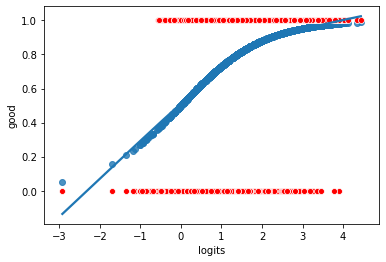

In [62]:
ax = sns.regplot(x='logits', y='prob', data=df_results, lowess=True)
sns.scatterplot(x='logits', y='good', data=df_results, ax=ax, color='r')

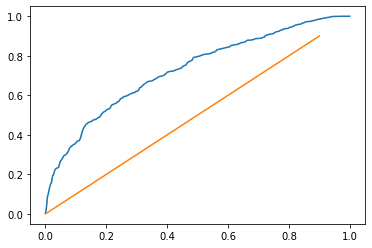

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax = sns.lineplot(x=fpr, y=tpr, ci=0, markers=True)
sns.lineplot(x=np.arange(0,1,0.1), y=np.arange(0,1,0.1), dashes=True, ax=ax)